In [1]:
import pandas as pd
import numpy as np
import os


In [2]:
labels=pd.read_csv('labels.csv')
labels.head()

,swim_id,stroke
0,eca387ee-efe3-4b52-b4ba-2ad59f9b3c56,Freestyle
1,ecc649a0-e9b7-4d89-bdb4-5446913720bf,Freestyle
2,9c3a0f82-003d-43d7-975a-0e63c2c59657,Freestyle
3,3b3dff00-08d4-4e19-8b56-ac95be0d755e,Freestyle
4,f2c736be-8c1a-4016-9cc9-d7875b40e996,BackStroke


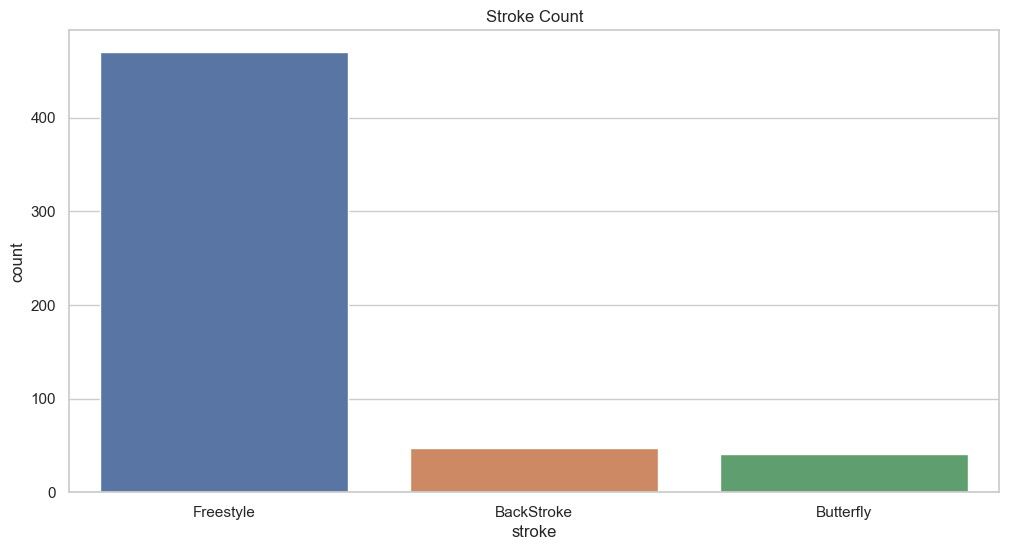

In [3]:
# show the count of stokes in labels in a bar chart
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="stroke", data=labels)
plt.title('Stroke Count')
plt.show()




In [5]:
dirs='./combined_2'
files=os.listdir(dirs)
files=[f for f in files
       if f.endswith('.csv')]
files[:10]

['0370272b-09b1-40d4-8d72-6c86765b3d4e.csv',
 'c5b09a5e-e3cd-4f1d-9da7-a2c2003752a1.csv',
 '42464b9f-e67c-4faf-beb8-ef7370266972.csv',
 '34ab80c6-a8f5-4981-b68f-de1a7527db90.csv',
 'c7b83f0b-149b-4d15-bc45-2118f644f6b5.csv',
 'daece0af-a9d3-44fe-906d-817cb4872686.csv',
 '3d467a08-0160-4240-bb19-4205a18a8557.csv',
 '9e296285-38fd-4703-9ae4-5ef0037c2eb1.csv',
 '0c9fbc6c-c909-456f-89a6-98ecdd4ab0b4.csv',
 '2ccca4eb-8cce-4219-aff7-cfb560702ad7.csv']

In [6]:
labels[labels['swim_id']=='0057f3aa-a1ec-4d6a-9776-846f6e8fd0e4']['stroke'].values[0]


'BackStroke'

In [7]:
# print columns
df=pd.read_csv(os.path.join(dirs,files[0]))
print(df.columns)

Index(['timestamp_1', 'fPressureFront_1', 'fPressureSide_1',
       'acceleration.x_1', 'acceleration.y_1', 'acceleration.z_1',
       'quaternion.i_1', 'quaternion.j_1', 'quaternion.k_1',
       'quaternion.real_1', 'timestamp_2', 'fPressureFront_2',
       'fPressureSide_2', 'acceleration.x_2', 'acceleration.y_2',
       'acceleration.z_2', 'quaternion.i_2', 'quaternion.j_2',
       'quaternion.k_2', 'quaternion.real_2'],
      dtype='object')


In [8]:

data_lst=[]
label_lst = []
count=0
features=[ 'fPressureFront_1', 'fPressureSide_1',
       'acceleration.x_1', 'acceleration.y_1', 'acceleration.z_1',
       'quaternion.i_1', 'quaternion.j_1', 'quaternion.k_1',
        'fPressureFront_2',
       'fPressureSide_2', 'acceleration.x_2', 'acceleration.y_2',
       'acceleration.z_2', 'quaternion.i_2', 'quaternion.j_2',
       'quaternion.k_2' ]
for file in files:
    count += 1
    df = pd.read_csv(os.path.join(dirs, file))
    df = pd.read_csv(os.path.join(dirs, file))
    # Drop the rows with missing values
    df = df.dropna()

    data = df[features].values
    # split the data into 200 rows each, and append to the data_lst
    # This is done to match the labels with the data
    for i in range(200, min(7000,len(data)-200), 200):
        data_lst.append(data[i:i+200])
        file = file.split('.')[0]
        label_str = labels[labels['swim_id'] == file]['stroke'].values
        label_dict = {'Freestyle': 0, 'BackStroke': 1, 'Butterfly': 2, 'BreastStroke': 3}
        label = np.array([label_dict[label_str[0]]]) if label_str.size > 0 else np.array([])

        if label.size > 0:
            label_lst.append(label[0])
        else:
            print(f"No label found for file: {file}")
    
    if count % 100 == 0:
        print(f"Processed {count} files")

Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files


In [11]:
# print the count of each stroke
from collections import Counter
print(Counter(label_lst))



Counter({0: 11833, 1: 895, 2: 578})


In [12]:
# only keep 1000 data with labels 0,keep all data with labels 1,2
data_lst_new = []
label_lst_new = []
count = 0
for data, label in zip(data_lst, label_lst):
    if label == 0 and count < 1000:
        data_lst_new.append(data)
        label_lst_new.append(label)
        count += 1
    elif label != 0:
        data_lst_new.append(data)
        label_lst_new.append(label)
print(Counter(label_lst_new))


Counter({0: 1000, 1: 895, 2: 578})


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_lst_new, label_lst_new, test_size=0.1, random_state=42, stratify=label_lst_new
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.11, random_state=42, stratify=y_train
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 1980
Validation size: 245
Test size: 248


In [16]:
# show the distribution of the labels in the train, validation and test sets

print("Train set distribution")
print(Counter(y_train))
print("Validation set distribution")
print(Counter(y_val))
print("Test set distribution")
print(Counter(y_test))


Train set distribution
Counter({0: 801, 1: 716, 2: 463})
Validation set distribution
Counter({0: 99, 1: 89, 2: 57})
Test set distribution
Counter({0: 100, 1: 90, 2: 58})


In [17]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


In [18]:
class SwimDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.LongTensor([self.targets[idx]])[0]

train_dataset = SwimDataset(X_train, y_train)
val_dataset = SwimDataset(X_val, y_val)
test_dataset = SwimDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [24]:
# print the shape of the data
data, target = next(iter(train_loader))
print(data.shape[-1])
print(target.shape)
print(data[0].shape)


16
torch.Size([32])
torch.Size([200, 16])


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score

# Implement the transformer
input_size = data.shape[-1]  
hidden_size = 32   # Hidden layer size
num_classes = 4
num_epochs = 10
learning_rate = 0.005
num_heads = 4     # Number of attention heads
num_layers = 5    # Number of transformer layers
dropout_rate = 0.3

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_heads, num_layers, dropout_rate):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x.transpose(0, 1))
        x = x[-1, :, :]
        x = self.dropout(x)
        out = self.fc(x)
        return out

# Assuming you have your data loaded in X_train, y_train, X_val, y_val
# Convert data to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Initialize model, loss function, and optimizer
model = TransformerModel(input_size, hidden_size, num_classes, num_heads, num_layers, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy_score(y_train, outputs.argmax(1))}")


    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        # Calculate other metrics like accuracy, F1-score, etc.


/Users/yixuanwang/anaconda3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


KeyboardInterrupt: 

In [27]:
#test the model on the test set
total = 0
correct = 0
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {(correct/total):.4f}')


Test Accuracy: 0.4032


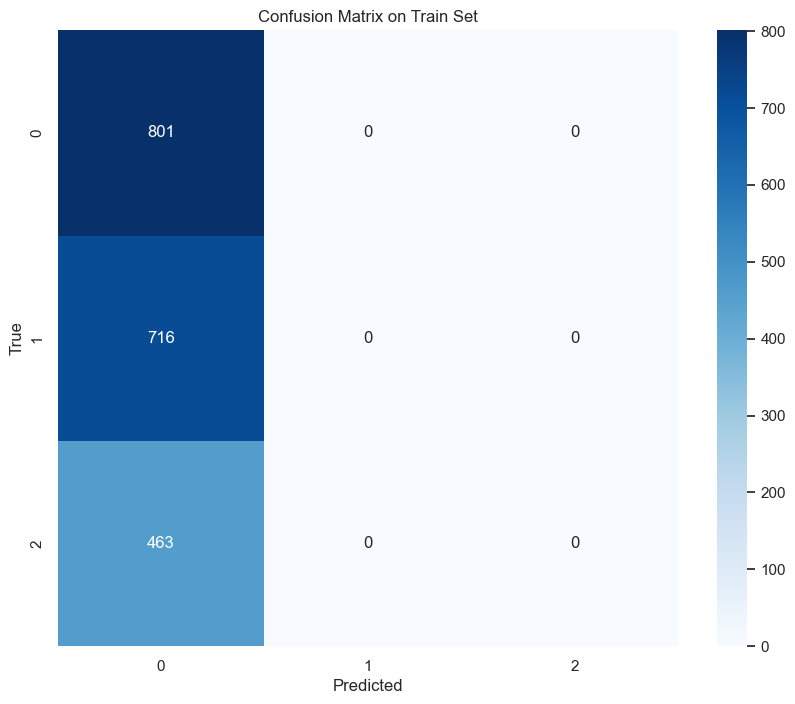

In [28]:
# show the confusion matrix on the train set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # Switch to evaluation mode
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Train Set')
plt.show()


In [130]:
label_dict

{'Freestyle': 0, 'BackStroke': 1, 'Butterfly': 2, 'BreastStroke': 3}

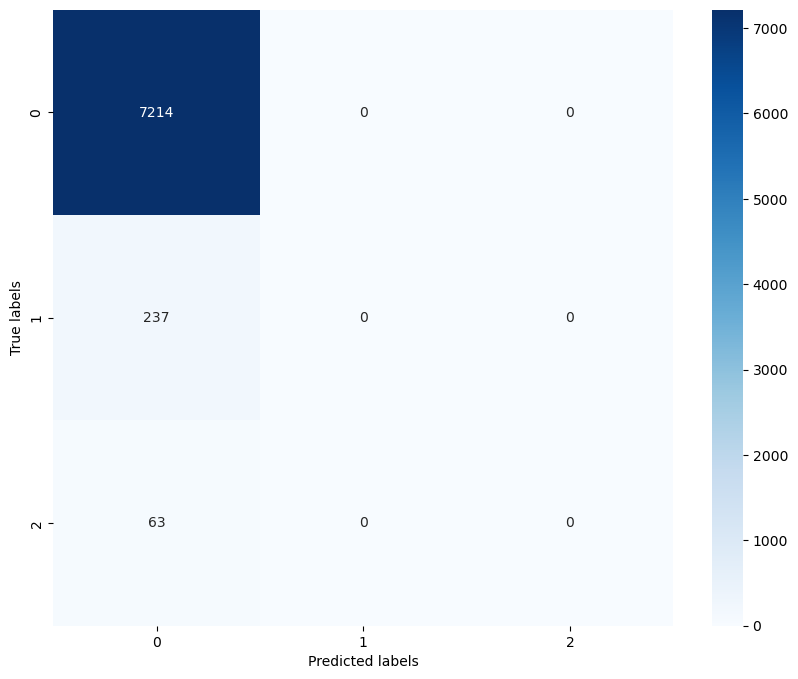

In [123]:
# show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # Switch to evaluation mode
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [131]:
# output the model parameters to a file
torch.save(model.state_dict(), 'transformer_model.pth')